In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers.legacy import RMSprop,Adam
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import re
import os
from PIL import Image
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Dense,LeakyReLU,BatchNormalization,Input,Conv2D,Flatten,Reshape,Conv2DTranspose
from tensorflow.keras.losses import BinaryCrossentropy
import torch
import gc

In [3]:
  def alphanumeric(data):
    def transform(text):
        return int(text) if text.isdigit() else text.lower()
    def alphanum_key(key):
        return [transform(i) for i in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [4]:
size = 128
image = []
path = '/content/drive/MyDrive/part1'
images = os.listdir(path)
images = alphanumeric(images)
for i in tqdm(images):
    if i == 'seed10000.png':
        break
    else:
            img = cv2.imread(path + '/'+i,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (size, size))
            img = (img - 127.5) / 127.5
            img = img.astype(float)
            image.append(img_to_array(img))

100%|██████████| 24/24 [00:01<00:00, 15.34it/s]


In [5]:
def build_discriminator():
    model = Sequential()
    model.add(Input((size, size, 3)))
    model.add(Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1,activation = 'sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0

In [6]:
latent_dim = 100
def build_generator():
    model = Sequential()

    model.add(Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))

    model.add(Reshape((128,128,3)))
    model.add(Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))

    model.add(LeakyReLU())
    model.add(Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))



    return model

In [7]:
generator = build_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 49152)             4915200   
                                                                 
 reshape (Reshape)           (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     6144      
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization_5 (Bat  (None, 64, 64, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                      

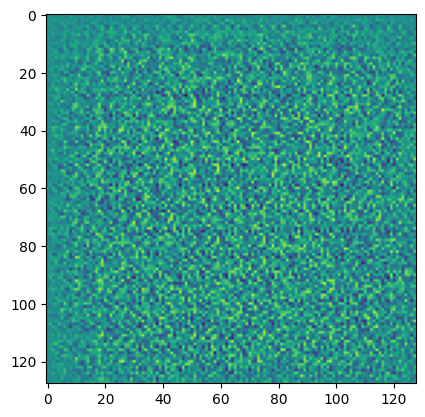

In [8]:
noise = np.random.normal(-1,1,(1,100))
.
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [8]:
optimizer = RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
      )


cross_entropy = BinaryCrossentropy(from_logits = False)

In [9]:
def g_loss(fake_image):
    return cross_entropy(tf.ones_like(fake_image),fake_image)
def d_loss(fake_image, real_image):
    fake_loss = cross_entropy(tf.zeros_like(fake_image),fake_image)
    real_loss = cross_entropy(tf.ones_like(real_image),real_image)
    return fake_loss + real_loss

<ipython-input-10-993ee0647206>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


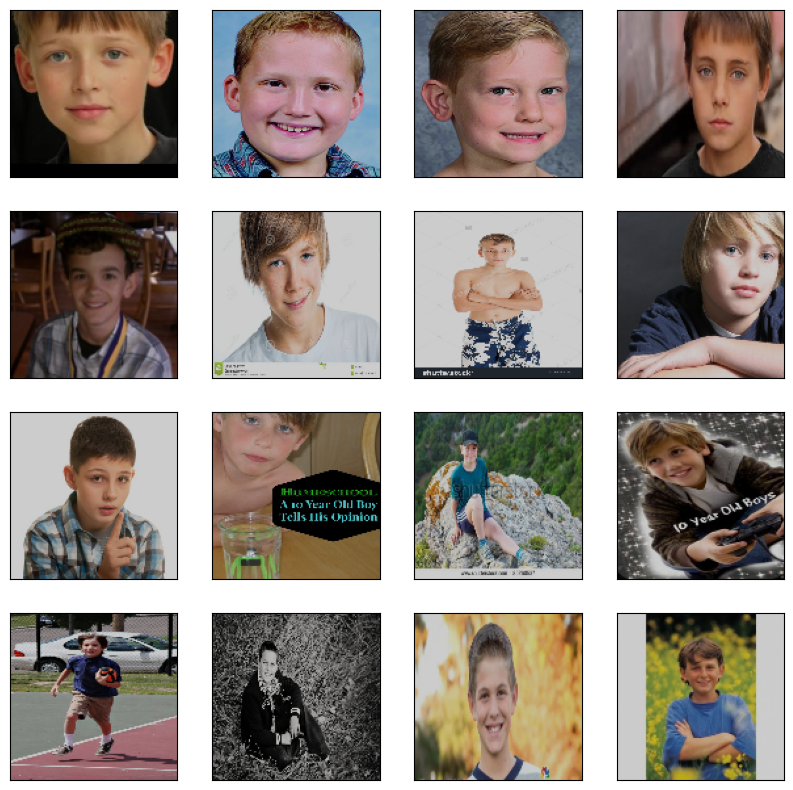

In [10]:
def plot_images(image, sqr = 4):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(image[i]*0.4 + 0.4 )
        plt.xticks([])
        plt.yticks([])


plot_images(image, 4)

<ipython-input-14-edde8cd7ae4e>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(sqr,sqr,i+1)


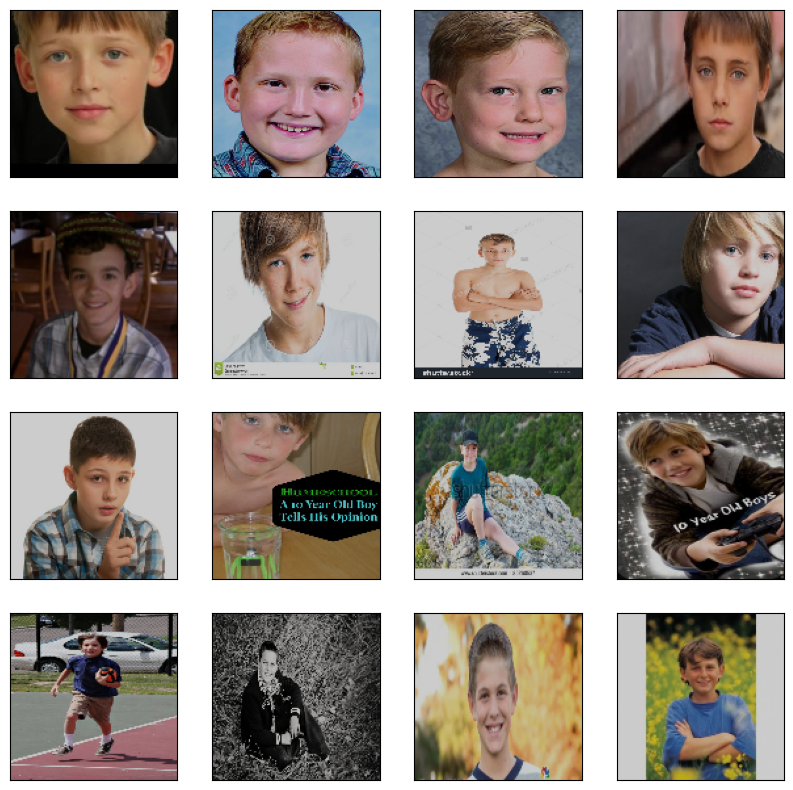

In [14]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(image[i]*0.4 + 0.4 )
        plt.xticks([])
        plt.yticks([])


plot_images(4)

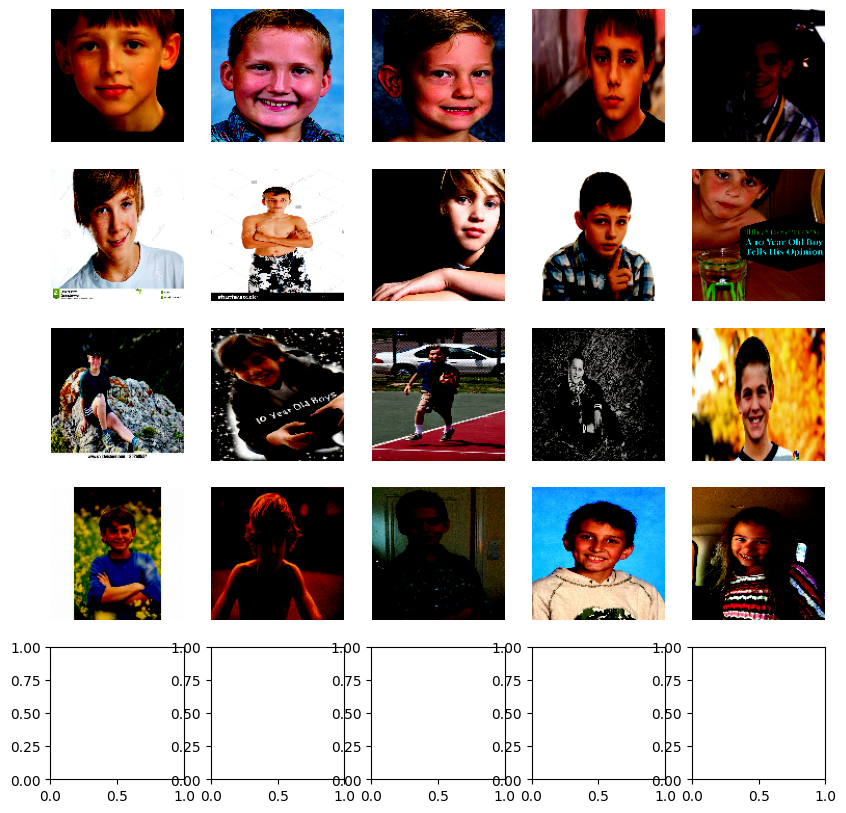

In [15]:
_, ax = plt.subplots(5, 5, figsize=(10, 10))

for i in range(4):
    for j in range(5):
        ax[i, j].imshow(image[5*i + j])
        ax[i, j].axis('off')

plt.show()

In [16]:
data = np.array(image)
print(data.shape)

(24, 128, 128, 3)


In [17]:
data = np.array(image)
print(data.shape)

(24, 128, 128, 3)


In [19]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(image)).batch(batch_size)

In [20]:
data  = np.array(dataset)
print(data.shape)

()


In [21]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_image = discriminator(generated_images)
        real_image = discriminator(images)

        gen_loss = g_loss(fake_image)
        dis_loss = d_loss(fake_image, real_image)


    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [22]:
def image_generator(square = 5, epochs = 0):
    plt.figure(figsize = (10,10))
    plt.suptitle("Non existing faces created", fontsize=20, color='black')
    for i in range(square * square):
        plt.subplot(square, square, i+1)
        noise = np.random.normal(0,1,(1,latent_dim))
        img = generator(noise)
        plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))

        plt.xticks([])
        plt.yticks([])
        plt.grid()

In [23]:
import time
def train(epochs,dataset):

    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch running/completed : {}".format(epoch + 1))
        for images in tqdm(dataset):
            loss = train_steps(images)
        print(" Time taken:{}".format(np.round(time.time() - start),2))
        print("Generator Loss is: {} Discriminator Loss is: {}".format(loss['gen loss'],loss['disc loss']))

In [24]:
gc.collect()

10

In [25]:
train(5,dataset)


Epoch running/completed : 1


100%|██████████| 1/1 [03:06<00:00, 186.06s/it]


 Time taken:186.0
Generator Loss is: 0.6128118634223938 Discriminator Loss is: 1.619381070137024

Epoch running/completed : 2


100%|██████████| 1/1 [03:21<00:00, 201.91s/it]


 Time taken:202.0
Generator Loss is: 3.332914275233634e-06 Discriminator Loss is: 12.685412406921387

Epoch running/completed : 3


100%|██████████| 1/1 [03:21<00:00, 201.91s/it]


 Time taken:202.0
Generator Loss is: 31.182910919189453 Discriminator Loss is: 0.3543231785297394

Epoch running/completed : 4


100%|██████████| 1/1 [03:21<00:00, 201.93s/it]


 Time taken:202.0
Generator Loss is: 9.239801147487015e-05 Discriminator Loss is: 9.347475051879883

Epoch running/completed : 5


100%|██████████| 1/1 [02:57<00:00, 177.42s/it]

 Time taken:177.0
Generator Loss is: 8.390981674194336 Discriminator Loss is: 0.0398673489689827


In [26]:
gc.collect()

0

In [27]:
train(1,dataset)


Epoch running/completed : 1


100%|██████████| 1/1 [03:21<00:00, 201.90s/it]

 Time taken:202.0
Generator Loss is: 2.5379717044415884e-05 Discriminator Loss is: 10.717509269714355


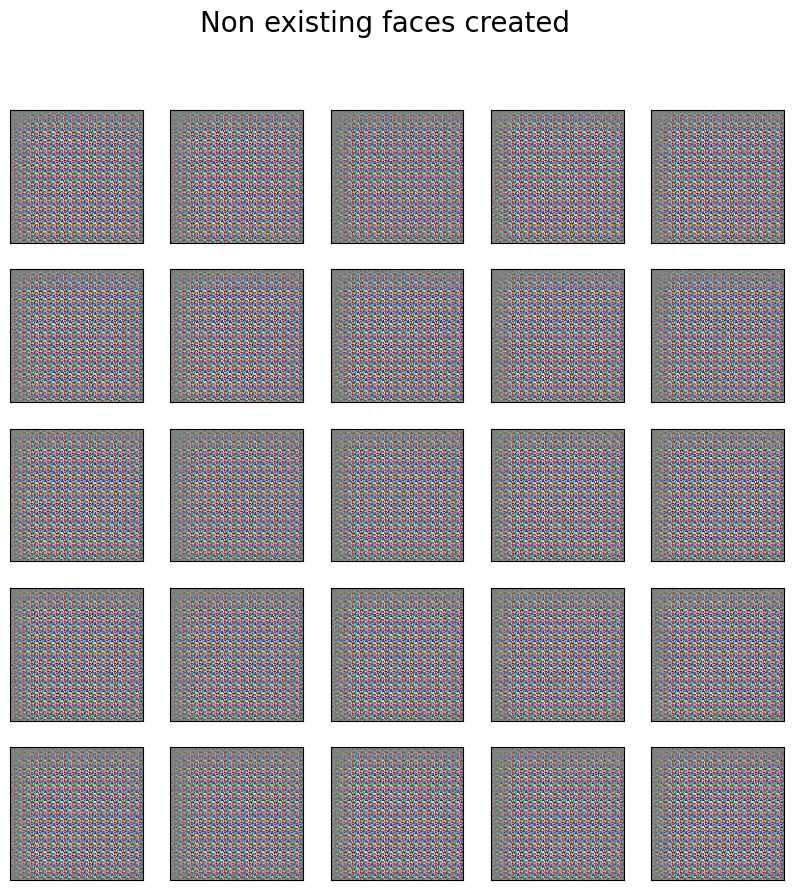

In [28]:
image_generator(5)